## Фінальний проєкт: ***"Аналіз цін продажу квартир у Польщі"***.

Проєкт присвячено дослідженню ринку **продажу квартир** у 15-ти найбільших містах Польщі з використанням Python, SQL та інструментів для візуалізації даних (Power BI Desktop).

## 🎯 Мета

Визначити, які фактори найбільше впливають на **ціну продажу квартири**, виявити регіональні відмінності та створити базову модель прогнозування вартості житла.


***Джерело даних:*** https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland/data.

***Опис даних:***

Набір даних містить пропозиції продажу квартир у 15 найбільших містах Польщі (Warsaw, Lodz, Krakow, Wroclaw, Poznan, Gdansk, Szczecin, Bydgoszcz, Lublin, Katowice, Bialystok, Czestochowa). Дані отримані з місцевих веб-сайтів з квартирами на продаж. Щоб повніше охопити околиці кожної квартири, кожну пропозицію було доповнено даними з Open Street Map з відстанями до визначних місць (POI). Дані збираються щомісяця та охоплюють період з серпня 2023 року по червень 2024 року.


***Поля даних***

`city` - назва міста, де розташована нерухомість;

`type` - тип будівлі;

`squareMeters` - площа квартири в квадратних метрах;

`rooms` - кількість кімнат у квартирі;

`floor` / `floorCount` - поверх, на якому розташована квартира, та загальна кількість поверхів у будівлі;

`buildYear` - рік побудови будівлі;

`latitude`, `longitude` - географічні координати нерухомості;

`centreDistance` - відстань від центру міста в км;


`poiCount` - кількість визначних місць у радіусі 500 м від квартири (школи, клініки, поштові відділення, дитячі садки, ресторани, коледжі, аптеки);

[poiName]Distance - відстань до найближчого визначного місця (школи, клініки, поштові відділення, дитячі садки, ресторани, коледжі, аптеки);

`ownership` - тип власності на нерухомість;

`condition` - стан квартири;

has[features] - чи має нерухомість ключові характеристики, такі як призначене паркомісце, балкон, ліфт, охорона, комора;

`price` - ціна пропозиції,  польський Злотий.


***Запитання, на які потрібно відповісти по результатам проведеного аналізу:***

1 Які фактори (ознаки) найбільше впливають на ціну квартири?

2 Як змінювалися ціни на квартири з серпня 2023 р. до червня 2024 р.?

3 Який рік побудови переважає в оголошеннях?

4 Як змінюється ціна залежно від міста/регіону (топ-5 міст за середньою ціною)?

5 Вплив площі та кількості кімнат на ціну.

6 Залежність ціни від відстані до центру.

7 Вплив типу житла (матеріалу будівлі).

8 Додаткові характеристики, що впливають на ціну.

9 Регіональна різниця в волатильності цін.

10 Якість моделі регресії та перенавчання.

## 1 Імпорт бібліотек

In [1]:
# Імпорт основних бібліотек
import os
import math
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import sqlite3

from pathlib import Path
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Налаштування відображення
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print('🔗 Libraries successfully loaded')

🔗 Libraries successfully loaded


## 2 Завантаження даних

In [2]:
# Завантаження окремих файлів, об'єднання їх в один датасет
def load_and_merge_monthly_data(data_path: str = "data") -> pd.DataFrame:
    """
    Завантажує щомісячні CSV-файли з орендою квартир у Польщі 
    та об’єднує їх у єдиний DataFrame.

    Кожен файл представляє дані за один місяць. 
    Функція автоматично додає стовпець 'report_date' 
    із відповідною датою звіту для подальшого аналізу 
    (наприклад, побудови трендів по місяцях).

    Args:
        data_path (str): шлях до директорії з CSV-файлами.

    Returns:
        pd.DataFrame: об’єднаний датасет з усіма місяцями 
        та колонкою 'report_date' у форматі datetime.
    """
    data_dir = Path(data_path)

    monthly_files = {
        "2023-08-01": "apartments_pl_2023_08.csv",
        "2023-09-01": "apartments_pl_2023_09.csv",
        "2023-10-01": "apartments_pl_2023_10.csv",
        "2023-11-01": "apartments_pl_2023_11.csv",
        "2023-12-01": "apartments_pl_2023_12.csv",
        "2024-01-01": "apartments_pl_2024_01.csv",
        "2024-02-01": "apartments_pl_2024_02.csv",
        "2024-03-01": "apartments_pl_2024_03.csv",
    }

    merged_frames = []

    for report_date, file_name in monthly_files.items():
        df_month = pd.read_csv(data_dir / file_name)
        df_month["report_date"] = report_date
        merged_frames.append(df_month)

    merged_data = pd.concat(merged_frames, ignore_index=True)
    merged_data["report_date"] = pd.to_datetime(merged_data["report_date"])

    print(f"✅ Завантажено та об’єднано записів: {len(merged_data):,}")

    return merged_data

rental_data = load_and_merge_monthly_data("data")


✅ Завантажено та об’єднано записів: 134,577


In [3]:
# Збереження об'єднаного датасету
rental_data.to_csv("data/rental_data_merged.csv", index=False)
print("✅ Об'єднаний файл збережено як rental_data_merged.csv")


✅ Об'єднаний файл збережено як rental_data_merged.csv


In [4]:
# Огляд перших 5 рядків датафрейму
rental_data.head(5)


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,report_date
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,6.53,9.0,0.118,1.389,0.628,0.105,1.652,NaN,0.413,condominium,concreteSlab,NaN,yes,yes,yes,no,yes,415000,2023-08-01
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,NaN,53.442692,14.559690,2.15,16.0,0.273,0.492,0.652,0.291,0.348,1.404,0.205,cooperative,concreteSlab,NaN,no,yes,yes,no,yes,395995,2023-08-01
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,3.24,9.0,0.275,0.672,0.367,0.246,0.300,1.857,0.280,condominium,brick,NaN,no,no,no,no,no,565000,2023-08-01
3,0a68cd14c44ec5140143ece75d739535,szczecin,tenement,87.60,3.0,2.0,3.0,NaN,53.435100,14.532900,2.27,32.0,0.175,0.259,0.223,0.359,0.101,0.310,0.087,condominium,brick,NaN,yes,yes,no,no,yes,640000,2023-08-01
4,f66320e153c2441edc0fe293b54c8aeb,szczecin,blockOfFlats,66.00,3.0,1.0,3.0,NaN,53.410278,14.503611,4.07,1.0,0.218,1.690,0.504,0.704,0.501,2.138,0.514,condominium,NaN,NaN,no,no,no,no,no,759000,2023-08-01


## 3 Аналіз пропущених значень

In [5]:
# Перевірка структури даних, розміру датафрейму
rental_data.info(verbose = True, show_counts=True)

rental_data.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134577 entries, 0 to 134576
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    134577 non-null  object        
 1   city                  134577 non-null  object        
 2   type                  104834 non-null  object        
 3   squareMeters          134577 non-null  float64       
 4   rooms                 134577 non-null  float64       
 5   floor                 110315 non-null  float64       
 6   floorCount            132816 non-null  float64       
 7   buildYear             112014 non-null  float64       
 8   latitude              134577 non-null  float64       
 9   longitude             134577 non-null  float64       
 10  centreDistance        134577 non-null  float64       
 11  poiCount              134577 non-null  float64       
 12  schoolDistance        134438 non-null  float64       
 13 

(134577, 29)

В об'єднаному датафреймі 134 577 рядків та 29 колонок.

In [6]:
# Кількість та відсоток пропущених значень по кожному показнику
missing_summary = pd.DataFrame({
    "missing_count": rental_data.isna().sum(),
    "missing_percent": (rental_data.isna().mean() * 100).round(2)
})

print("\nMissing values summary per column:")
print(missing_summary)



Missing values summary per column:
                      missing_count  missing_percent
id                                0             0.00
city                              0             0.00
type                          29743            22.10
squareMeters                      0             0.00
rooms                             0             0.00
floor                         24262            18.03
floorCount                     1761             1.31
buildYear                     22563            16.77
latitude                          0             0.00
longitude                         0             0.00
centreDistance                    0             0.00
poiCount                          0             0.00
schoolDistance                  139             0.10
clinicDistance                  548             0.41
postOfficeDistance              189             0.14
kindergartenDistance            157             0.12
restaurantDistance              366             0.27
collegeDis

### Подивлюсь базову статистику для числових змінних і моду - для всіх змінних

In [7]:
# Базова статистика для числових змінних
numeric_stats = rental_data.describe().round(2)

print("Базова статистика для всіх числових змінних:")
print(numeric_stats)


Базова статистика для всіх числових змінних:
       squareMeters      rooms      floor  floorCount  buildYear   latitude  \
count     134577.00  134577.00  110315.00   132816.00  112014.00  134577.00   
mean          59.29       2.70       3.31        5.25    1985.49      52.04   
min           25.00       1.00       1.00        1.00    1850.00      49.98   
25%           44.54       2.00       2.00        3.00    1966.00      51.11   
50%           55.20       3.00       3.00        4.00    1994.00      52.20   
75%           69.50       3.00       4.00        6.00    2015.00      52.44   
max          150.00       6.00      29.00       29.00    2024.00      54.61   
std           21.66       0.92       2.51        3.28      34.20       1.35   

       longitude  centreDistance   poiCount  schoolDistance  clinicDistance  \
count  134577.00       134577.00  134577.00       134438.00       134029.00   
mean       19.46            4.32      20.72            0.41            0.97   
min   

In [8]:
# Обчислюю моди для всіх змінних
modes = rental_data.mode().iloc[0]

# Частка моди у відсотках від загальної кількості рядків
percent = (rental_data.eq(modes).sum() / len(rental_data) * 100).round(2)

# Перетворюю в DataFrame для зручного виводу
modes_df = modes.to_frame(name="mode")
modes_df["percent"] = percent

print("\n Мода для всіх змінних з відсотком:")
print(modes_df)



 Мода для всіх змінних з відсотком:
                                                  mode  percent
id                    000f9c10ab7bab5e21b0409df27145a5     0.01
city                                          warszawa    29.55
type                                      blockOfFlats    45.70
squareMeters                                      48.0     1.27
rooms                                              2.0    40.17
floor                                              1.0    19.65
floorCount                                         4.0    31.62
buildYear                                       2023.0     4.75
latitude                                        53.126     0.60
longitude                                      18.0079     0.59
centreDistance                                    0.65     0.67
poiCount                                           0.0     5.17
schoolDistance                                   0.111     0.81
clinicDistance                                   0.205     0.66
pos

### Висновок з аналізу пропущених значень

- Колонку `condition` видаляю з датасету повністю, оскільки в ній > 40% пропущених значень.

-  Відсутні значення в таких стовпцях, як: `collegeDistance` (2.84%, float64), `clinicDistance` (0.41%, float64), `restaurantDistance` (0.27%, float64), `pharmacyDistance` (0.15%, float64), `postOfficeDistance` (0.14%, float64), `kindergartenDistance` (0.12%, float64), `schoolDistance` (0.10%, float64) заповнюю середнім значенням по цій колонці.

- Такі колонки, як: `buildingMaterial` (39.03%, object), `type` (22.10%, object), `floor` (18.03%, float64),  `buildYear` (16.77%, float64), `hasElevator` (5.07%, object), `floorCount` (1.31%, float64) проаналізую окремо, щоб прийняти остаточне рішення щодо доцільності і способу заповнення відсутніх значень в кожній з колонок.


### Видалення колонки `condition` з датафрейму

In [9]:
rental_data.drop(columns=['condition'], inplace=True)


In [10]:
# Перевіряю наявнісь колонки 'condition'
print(rental_data.columns.tolist())


['id', 'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear', 'latitude', 'longitude', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance', 'ownership', 'buildingMaterial', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom', 'price', 'report_date']


Колонка `condition` відсутня

### Заповнення пропусків середнім значенням в колонках `collegeDistance`, `clinicDistance`, `restaurantDistance`, `pharmacyDistance` , `postOfficeDistance`, `kindergartenDistance`, `schoolDistance`


In [11]:
# Заповнюю пропуски середніми значеннями для вибраних колонок
cols_to_fill = [
    "collegeDistance",
    "clinicDistance",
    "restaurantDistance",
    "pharmacyDistance",
    "postOfficeDistance",
    "kindergartenDistance",
    "schoolDistance"
]

# Переконуюсь, що стовпці належать до числових типів
rental_data[cols_to_fill] = rental_data[cols_to_fill].apply(
    pd.to_numeric, errors="coerce"
)

# Заповнюю пропуски середнім значенням для кожної колонки
rental_data[cols_to_fill] = rental_data[cols_to_fill].fillna(
    rental_data[cols_to_fill].mean()
)

print("✅ Пропущені значення заповнено середнім для вибраних колонок.")


✅ Пропущені значення заповнено середнім для вибраних колонок.


### Аналіз стовпця `buildingMaterial` (39.03% пропущених значень)

In [12]:
rental_data['buildingMaterial'].value_counts()

buildingMaterial
brick           64337
concreteSlab    17717
Name: count, dtype: int64

In [13]:
# Заповнюю пропущені значення матеріалу будівлі найпоширенішим (модою) — 'brick'
rental_data['buildingMaterial'] = rental_data['buildingMaterial'].fillna('brick')

# Перевіряю відсутність пропусків
rental_data['buildingMaterial'].isna().sum()

np.int64(0)

### Аналіз стовпця `buildYear` (16.77% пропущених значень)

In [14]:
rental_data['buildYear'].value_counts()


buildYear
2023.0    6395
2022.0    6027
1980.0    4663
1970.0    4318
1960.0    3008
          ... 
1861.0       2
1864.0       1
1884.0       1
1856.0       1
1869.0       1
Name: count, Length: 165, dtype: int64

In [15]:
# Фільтрую рядки, де рік побудови відсутній
missing_buildyear = rental_data[rental_data['buildYear'].isna()]

# Групую за типом будівлі та матеріалам
missing_summary = (
    missing_buildyear
    .groupby(['floorCount', 'buildingMaterial'])
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)
)

# Додаю частку відносно всіх оголошень
missing_summary['missing_percent'] = (
    (missing_summary['missing_count'] / len(rental_data) * 100).round(2)
)

print("📈 Пропуски у 'buildYear' за типом будівлі та матеріалом:")
print(missing_summary)

📈 Пропуски у 'buildYear' за типом будівлі та матеріалом:
    floorCount buildingMaterial  missing_count  missing_percent
6          4.0            brick           6888             5.12
4          3.0            brick           3835             2.85
2          2.0            brick           1991             1.48
18        10.0            brick           1517             1.13
8          5.0            brick           1474             1.10
7          4.0     concreteSlab           1135             0.84
0          1.0            brick            863             0.64
19        10.0     concreteSlab            671             0.50
10         6.0            brick            650             0.48
21        11.0     concreteSlab            411             0.31
20        11.0            brick            354             0.26
12         7.0            brick            352             0.26
14         8.0            brick            347             0.26
16         9.0            brick            212 

In [16]:
# Заповнюю пропуски у 'buildYear' за медіаною всередині групи (floorCount та buildingMaterial)
rental_data['buildYear'] = (
    rental_data
    .groupby(['floorCount', 'buildingMaterial'])['buildYear']
    .transform(lambda x: x.fillna(x.median()))
)

# Перевіряю відсутність пропусків
rental_data['buildYear'].isna().sum()


np.int64(1761)

In [17]:
# Заповнюю залишкові пропуски глобально медіаною
rental_data['buildYear'] = rental_data['buildYear'].fillna(
    rental_data['buildYear'].median()
)

# Перевіряю відсутність пропусків
rental_data['buildYear'].isna().sum()


np.int64(0)

### Аналіз стовпця `type` (22.10 % пропущених значень)

In [18]:
rental_data['type'].value_counts()


type
blockOfFlats         61496
apartmentBuilding    22348
tenement             20990
Name: count, dtype: int64

In [19]:
# Фільтрую рядки, де тип будівлі відсутній
# Групую за поверхом і загальною кількістю поверхів у будівлі
# Додаю частку відносно всіх оголошень

missing_type_summary = (
    rental_data[rental_data['type'].isna()]
    .groupby(['floor', 'floorCount'])
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)
)
missing_type_summary['missing_percent'] = (
    (missing_type_summary['missing_count'] / len(rental_data) * 100).round(2)
)

print("📈 Пропуски у 'type' за поверхом і загальною кількістю поверхів у будівлі:")
print(missing_type_summary)


📈 Пропуски у 'type' за поверхом і загальною кількістю поверхів у будівлі:
     floor  floorCount  missing_count  missing_percent
52     4.0         4.0           2071             1.54
38     3.0         4.0           1745             1.30
37     3.0         3.0           1731             1.29
20     2.0         4.0           1511             1.12
3      1.0         4.0           1443             1.07
..     ...         ...            ...              ...
193   18.0        21.0              1             0.00
195   18.0        28.0              1             0.00
196   19.0        23.0              1             0.00
201   24.0        26.0              1             0.00
200   23.0        23.0              1             0.00

[204 rows x 4 columns]


***Висновок:*** пропуски в колонці `type` спостерігаються на різних поверхах, включно з крайніми. Для заповнення доцільно використати моду — `blockOfFlats` (45,70 % від усіх значень).

In [20]:
# Використовую вже обчислену моду для 'type'
mode_type = modes['type']

# Заповнюю пропуски модою
rental_data['type'] = rental_data['type'].fillna(mode_type)

# Перевірка
rental_data['type'].isna().sum()


np.int64(0)

### Аналіз стовпця `floorCount` (1.31 % пропущених значень)

In [21]:
rental_data['floorCount'].value_counts


<bound method IndexOpsMixin.value_counts of 0         10.0
1         10.0
2          3.0
3          3.0
4          3.0
          ... 
134572     2.0
134573     3.0
134574     4.0
134575     2.0
134576     1.0
Name: floorCount, Length: 134577, dtype: float64>

In [22]:
# Заповнюю пропуски в стовпці `floorCount` середнім значенням
rental_data['floorCount'].fillna(rental_data['floorCount'].mean(), inplace=True)


In [23]:
# Перевіряю наявність пропущених значень
rental_data['type'].isna().sum()


np.int64(0)

### Аналіз стовпця `floor` (18.03 % пропущених значень)

In [24]:
rental_data['floor'].value_counts()


floor
1.0     26450
3.0     23140
2.0     22969
4.0     16694
5.0      6216
6.0      3607
7.0      2959
8.0      2308
9.0      1933
10.0     1866
11.0      773
12.0      435
14.0      297
13.0      230
15.0      154
17.0      135
16.0       59
18.0       19
20.0       17
29.0       15
22.0       12
23.0       10
24.0       10
19.0        5
21.0        2
Name: count, dtype: int64

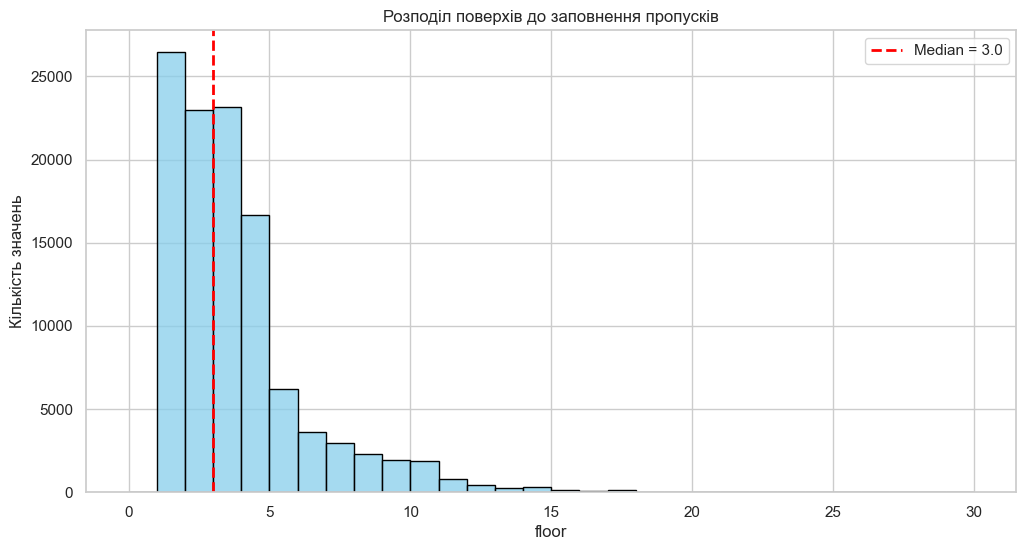

In [25]:
# Графік до заповнення пропусків
floor_before = rental_data['floor'].copy()

plt.figure(figsize=(12, 6))
sns.histplot(floor_before, bins=range(0, int(floor_before.max()) + 2), 
             color='skyblue', edgecolor='black')
median_before = floor_before.median()
plt.axvline(median_before, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_before}')
plt.title('Розподіл поверхів до заповнення пропусків')
plt.xlabel('floor')
plt.ylabel('Кількість значень')
plt.legend()
plt.show()


In [26]:
# Заповнюємо для будинків з 1 поверхом
rental_data.loc[
    (rental_data['floorCount'] == 1) & (rental_data['floor'].isna()),
    'floor'
] = 1

# Медіана по групі 'floorCount', тільки для непорожніх груп
def fill_median_safe(x):
    if x.notna().sum() == 0:
        return x  # залишає NaN
    return x.fillna(x.median())

rental_data['floor'] = rental_data.groupby('floorCount')['floor'].transform(fill_median_safe)

# Глобальна медіана для решти пропусків
median_floor = rental_data['floor'].median()
rental_data['floor'] = rental_data['floor'].fillna(median_floor)


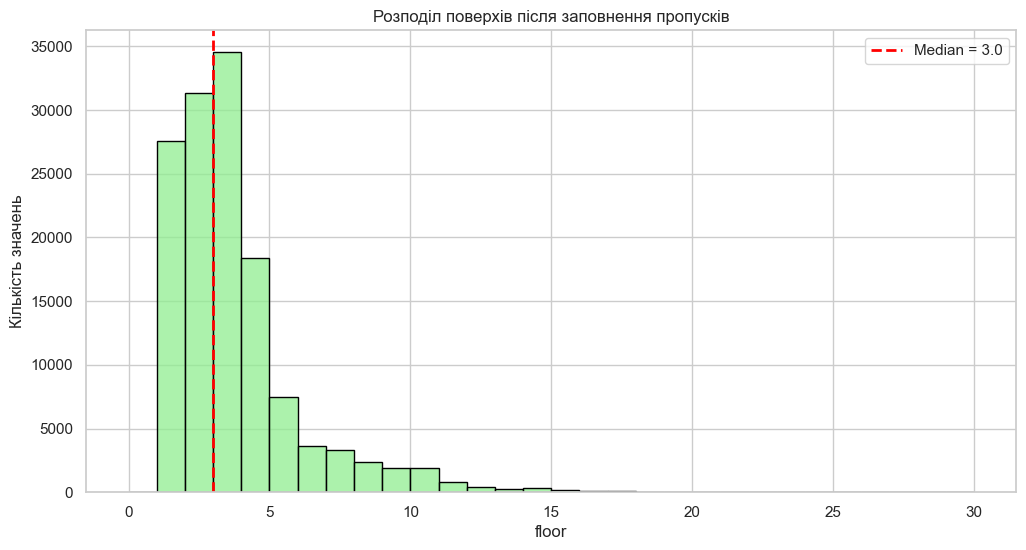

In [27]:
# Графік після заповнення пропусків
floor_after = rental_data['floor'].copy()

plt.figure(figsize=(12, 6))
sns.histplot(floor_after, bins=range(0, int(floor_after.max()) + 2), 
             color='lightgreen', edgecolor='black')
median_after = floor_after.median()
plt.axvline(median_after, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_after}')
plt.title('Розподіл поверхів після заповнення пропусків')
plt.xlabel('floor')
plt.ylabel('Кількість значень')
plt.legend()
plt.show()


***Висновок:*** розподіл після заповнення пропусків практично не змінився за формою чи медіаною, лише зріс обсяг даних.

Це свідчить, що метод заповнення пропусків був обраний правильно, адже:

- не змістив центральну тенденцію (медіану);

- зберіг реалістичний розподіл;

- уникнув створення штучних піків або спотворень.

In [28]:
# Перевіряю, чи залишились пропуски
rental_data['floor'].isna().sum()


np.int64(0)

### Аналіз стовпця `hasElevator` (5.07 % пропущених значень)

In [29]:
rental_data['hasElevator'].value_counts


<bound method IndexOpsMixin.value_counts of 0         yes
1         yes
2          no
3          no
4          no
         ... 
134572     no
134573     no
134574     no
134575     no
134576     no
Name: hasElevator, Length: 134577, dtype: object>

In [30]:
# Заповнюю пропуски відповідно до значень в стовпчику 'floor' - наявність ліфта для квартир від 6-го поверху і вище
# Створюю маску для пропусків
mask_na = rental_data['hasElevator'].isna()

# Заповню. пропуски векторизовано
rental_data.loc[mask_na & (rental_data['floor'] >= 6), 'hasElevator'] = 'yes'
rental_data.loc[mask_na & (rental_data['floor'] < 6), 'hasElevator'] = 'no'


In [31]:
# Перевіряю, чи залишились пропуски
rental_data['hasElevator'].isna().sum()


np.int64(0)

### Додаю колонку з ціною за квадратний метр

In [32]:
rental_data["price_per_m2"] = (rental_data["price"] / rental_data["squareMeters"]).round(4)


### Створення готового файлу

In [33]:
DATA_FILE = Path("rental_data_clean.csv")


In [34]:
# Конвертую дати
rental_data["report_date"] = pd.to_datetime(rental_data["report_date"])


In [35]:
# Зберігаю очищений файл
rental_data.to_csv(DATA_FILE, index=False, encoding="utf-8")
print("💾 Файл 'rental_data_clean.csv' створено та збережено.")


💾 Файл 'rental_data_clean.csv' створено та збережено.


In [36]:
# Перевірка структури фінального датасету
print("\n🔍 Інформація про фінальний датафрейм:")
rental_data.info()

print("\n Перші 5 рядків даних:")
display(rental_data.head())



🔍 Інформація про фінальний датафрейм:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134577 entries, 0 to 134576
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    134577 non-null  object        
 1   city                  134577 non-null  object        
 2   type                  134577 non-null  object        
 3   squareMeters          134577 non-null  float64       
 4   rooms                 134577 non-null  float64       
 5   floor                 134577 non-null  float64       
 6   floorCount            134577 non-null  float64       
 7   buildYear             134577 non-null  float64       
 8   latitude              134577 non-null  float64       
 9   longitude             134577 non-null  float64       
 10  centreDistance        134577 non-null  float64       
 11  poiCount              134577 non-null  float64       
 12  schoolDistance     

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,report_date,price_per_m2
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,6.53,9.0,0.118,1.389,0.628,0.105,1.652,1.440759,0.413,condominium,concreteSlab,yes,yes,yes,no,yes,415000,2023-08-01,6587.3016
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,1976.0,53.442692,14.559690,2.15,16.0,0.273,0.492,0.652,0.291,0.348,1.404000,0.205,cooperative,concreteSlab,no,yes,yes,no,yes,395995,2023-08-01,10999.8611
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,2000.0,53.452222,14.553333,3.24,9.0,0.275,0.672,0.367,0.246,0.300,1.857000,0.280,condominium,brick,no,no,no,no,no,565000,2023-08-01,7737.6061
3,0a68cd14c44ec5140143ece75d739535,szczecin,tenement,87.60,3.0,2.0,3.0,2000.0,53.435100,14.532900,2.27,32.0,0.175,0.259,0.223,0.359,0.101,0.310000,0.087,condominium,brick,yes,yes,no,no,yes,640000,2023-08-01,7305.9361
4,f66320e153c2441edc0fe293b54c8aeb,szczecin,blockOfFlats,66.00,3.0,1.0,3.0,2000.0,53.410278,14.503611,4.07,1.0,0.218,1.690,0.504,0.704,0.501,2.138000,0.514,condominium,brick,no,no,no,no,no,759000,2023-08-01,11500.0000


***Висновок:*** всі пропуски заповнені, дані очищені та готові до подальшого аналізу. Можна переходити до побудови моделей, візуалізацій та аналітики.

## 4 Дослідницький аналіз (EDA)

In [37]:
# Базова статистика лише для ключових показників
key_columns = ['price', 'squareMeters', 'price_per_m2', 'rooms']
print("Базова статистика для ключових показників:")
stats = rental_data[key_columns].describe().round(2)

print(stats)


Базова статистика для ключових показників:
            price  squareMeters  price_per_m2      rooms
count   134577.00     134577.00     134577.00  134577.00
mean    765976.72         59.29      13110.62       2.70
std     397422.84         21.66       4883.97       0.92
min     150000.00         25.00       3000.00       1.00
25%     500000.00         44.54       9375.00       2.00
50%     685000.00         55.20      12499.98       3.00
75%     903000.00         69.50      16120.29       3.00
max    3250000.00        150.00      31041.67       6.00


**🏠 Ключові показники квартир: (висновки з базової статистики)** 

💰 Середня ціна: ~ 766 тис. PLN.

📏 Середня площа: ~ 59 м².

💵 Середня ціна за м²: ~ 13,1 тис. PLN/m².

🛋️ Кімнат: 2–3.

✨ Розкид значень показує наявність як бюджетних, так і преміум-квартир.


## 5 SQL analysis

In [38]:
# Створюю базу SQLite та імпортую очищені дані
DB_FILE = Path("rental_data.db")
conn = sqlite3.connect(DB_FILE)

# Завантажую DataFrame у базу
rental_data.to_sql("rental_data", conn, index=False, if_exists="replace")
print(f" Дані завантажено в базу SQLite: {DB_FILE}")

# Перевіряю структуру таблиці
print("\n Структура таблиці 'rental_data':")
pd.read_sql("PRAGMA table_info(rental_data);", conn)


 Дані завантажено в базу SQLite: rental_data.db

 Структура таблиці 'rental_data':


,cid,name,type,notnull,dflt_value,pk
0,0,id,TEXT,0,None,0
1,1,city,TEXT,0,None,0
2,2,type,TEXT,0,None,0
3,3,squareMeters,REAL,0,None,0
4,4,rooms,REAL,0,None,0
5,5,floor,REAL,0,None,0
6,6,floorCount,REAL,0,None,0
7,7,buildYear,REAL,0,None,0
8,8,latitude,REAL,0,None,0
9,9,longitude,REAL,0,None,0


In [39]:
# Перевіряю розподіл за містами
query_city_summary = """
SELECT 
    city,
    COUNT(*) AS listings,
    ROUND(AVG(price), 0) AS avg_price,
    ROUND(AVG(squareMeters), 1) AS avg_area,
    ROUND(AVG(price_per_m2), 0) AS avg_price_per_m2
FROM rental_data
GROUP BY city
ORDER BY avg_price_per_m2 DESC;
"""
city_summary = pd.read_sql(query_city_summary, conn)

print("\n Середні показники по містах:")
display(city_summary)



 Середні показники по містах:


,city,listings,avg_price,avg_area,avg_price_per_m2
0,warszawa,39764,1004781.0,60.7,16791.0
1,krakow,19866,876025.0,57.8,15473.0
2,gdansk,13649,821065.0,59.1,14241.0
3,wroclaw,13554,722497.0,59.2,12550.0
4,gdynia,5817,785185.0,63.8,12366.0
5,poznan,5431,631878.0,61.9,10531.0
6,rzeszow,1316,539619.0,57.0,9738.0
7,lublin,4122,545016.0,60.8,9106.0
8,bialystok,1836,462956.0,53.3,8856.0
9,szczecin,4373,541273.0,65.6,8611.0


***Висновки по середнім показникам по містах:***

- Найдорожчі міста за ціною/м²: warszawa (16 791), krakow (15 473), gdansk (14 241).

- Найдешевші: bydgoszcz	 (7 666), radom (6 442), czestochowa (6 414).

- Середня площа квартир коливається від ~53 м² (bialystok, czestochowa) до ~66 м² (szczecin).

- Найбільше пропозицій: warszawa (39 764), krakow (19 866), gdansk (13649).

- Варшава — лідер за кількістю оголошень і середньою ціною, тоді як менші міста пропонують дешевші квартири, часто меншої площі.

- Загальна тенденція: великі міста дорожчі і компактніші, малі — дешевші, іноді з більшою площею на м².

In [40]:
# Вплив кількості кімнат на середню ціну
query_1 = """
SELECT
    rooms,
    COUNT(*) AS total_listings,
    ROUND(AVG(price), 2) AS avg_price
FROM rental_data
GROUP BY rooms
ORDER BY avg_price DESC;
"""
print("\n Вплив кількості кімнат на середню ціну:")
display(pd.read_sql_query(query_1, conn))



 Вплив кількості кімнат на середню ціну:


,rooms,total_listings,avg_price
0,6.0,1169,1635240.44
1,5.0,3678,1251302.03
2,4.0,17650,1051871.02
3,3.0,50566,818053.22
4,2.0,54058,616358.21
5,1.0,7456,445100.49


***Висновки по впливу кількості кімнат на середню ціну***

- Ціна зростає з кількістю кімнат: 1-кімнатні — ~445 тис.PLN, 6-кімнатні — ~1,63 млн.PLN

- Найпопулярніші — 2–3-кімнатні квартири (54 058 і 50 566 оголошень відповідно), тобто більшість ринку орієнтована на середній сегмент.

- Великі квартири (5–6 кімнат) зустрічаються рідше, але їх середня ціна значно вища.

- Тенденція чітка: ціна пропорційна площі і кількості кімнат, що логічно відображає житлові потреби і вартість нерухомості.

In [41]:
# Вплив поверху на середню ціну
query_2 = """
SELECT
    floor,
    COUNT(*) AS total_listings,
    ROUND(AVG(price), 2) AS avg_price
FROM rental_data
WHERE floor IS NOT NULL
GROUP BY floor
ORDER BY avg_price DESC;
"""
print("\n Вплив поверху на середню ціну:")
display(pd.read_sql_query(query_2, conn))



 Вплив поверху на середню ціну:


,floor,total_listings,avg_price
0,29.0,15,2200000.00
1,22.0,12,1377333.33
2,17.0,135,1323525.93
3,18.0,19,1218870.37
4,24.0,10,1043200.00
5,13.0,230,1030627.33
6,19.0,5,993730.00
7,20.0,17,987640.47
8,14.0,300,978713.02
9,15.0,154,970249.16


***Висновок***

Середня ціна квартир за поверхом показує тенденцію зниження від високих до низьких поверхів у більшості випадків. Найвищі середні ціни спостерігаються на екстремально високих поверхах (наприклад, 29-й поверх – 2,2 млн. PLN), а найнижчі – на верхніх “рідкісних” поверхах та деяких середніх (наприклад, 21-й та 23-й – близько 0,54–0,56 млн. PLN). Найбільша кількість оголошень сконцентрована на нижніх та середніх поверхах (1–4-й та 10–12-й), де середня ціна стабільно нижча за 0,85 млн. PLN.

Отже, ціна зростає на високих поверхах із невеликою кількістю пропозицій, а на популярних нижніх та середніх поверхах – нижча.

In [42]:
# Середня ціна за м² по типу будівлі
query_3 = """
SELECT buildingMaterial, 
       COUNT(*) AS total_listings, 
       ROUND(AVG(price_per_m2), 2) AS avg_price_per_m2
FROM rental_data
WHERE buildingMaterial IS NOT NULL --ігноруєм пропущені рядки, відповідно до прийнятого раніше рішення
GROUP BY buildingMaterial
ORDER BY avg_price_per_m2 DESC;
"""
print("\n Середня ціна за м² по типу будівлі:")
display(pd.read_sql_query(query_3, conn))



 Середня ціна за м² по типу будівлі:


,buildingMaterial,total_listings,avg_price_per_m2
0,brick,116860,13487.71
1,concreteSlab,17717,10623.37


***Висновок***

Середня ціна за м² залежить від типу будівлі: найдорожчі — цегляні будинки, найдешевші — панельні (concreteSlab).

In [43]:
# Середня площа квартир по містах
query_4 = """
SELECT
    city,
    ROUND(AVG(squareMeters), 2) AS avg_squareMeters,
    COUNT(*) AS total_listings
FROM rental_data
GROUP BY city
ORDER BY avg_squareMeters DESC;
"""
print("\n📏 Середня площа квартир по містах:")
display(pd.read_sql_query(query_4, conn))



📏 Середня площа квартир по містах:


,city,avg_squareMeters,total_listings
0,szczecin,65.65,4373
1,gdynia,63.81,5817
2,poznan,61.88,5431
3,katowice,61.20,3704
4,lublin,60.85,4122
5,warszawa,60.69,39764
6,wroclaw,59.19,13554
7,gdansk,59.09,13649
8,krakow,57.82,19866
9,rzeszow,56.96,1316


***Висновок***

Середня площа квартир найбільша у szczecin та gdynia (≈64–66 м²), а найменша — у bialystok і czestochowa (≈53 м²). Загалом у великих містах, як warszawa та krakow, площа трохи менша за топові, але кількість пропозицій значно більша.

In [44]:
# Рік побудови по всім містам
query_5 = """
SELECT 
    buildYear,
    COUNT(*) AS count_buildings
FROM rental_data
WHERE buildYear IS NOT NULL
GROUP BY buildYear
ORDER BY count_buildings DESC;
"""
print("\n Рік побудови по містах:")
display(pd.read_sql_query(query_5, conn))



 Рік побудови по містах:


,buildYear,count_buildings
0,1980.0,11760
1,2023.0,6348
2,2022.0,6007
3,2000.0,5968
4,1970.0,4307
...,...,...
161,1983.5,1
162,1884.0,1
163,1869.0,1
164,1864.0,1


***Висновок:*** більшість будинків зведено у другій половині XX століття, з піком у 1980 році, а також активно будуються нові об’єкти у 2022–2023 роках. Історичні будівлі XIX століття представлені поодинокими екземплярами.

In [45]:
# Завершення роботи з базою даних SQLite
# 🔒 Закриваємо підключення
conn.close()

print("✅ Підключення до бази даних закрито.")


✅ Підключення до бази даних закрито.


## 6 Побудова моделі лінійної регресії, що прогнозує вартість житла в Польщі

In [46]:
# Очищення даних та видалення викидів
rental_data = rental_data[rental_data['price'].notna()].copy()

# Межі для викидів
Q1 = rental_data["price"].quantile(0.25)
Q3 = rental_data["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print(f"Межі для викидів: {lower_bound:.0f} – {upper_bound:.0f}")


Межі для викидів: -104500 – 1507500


In [47]:
# Видалення викидів
rental_data = rental_data[(rental_data["price"] >= lower_bound) & (rental_data["price"] <= upper_bound)]

print("Розмір датасету після видалення викидів:", rental_data.shape)


Розмір датасету після видалення викидів: (127669, 29)


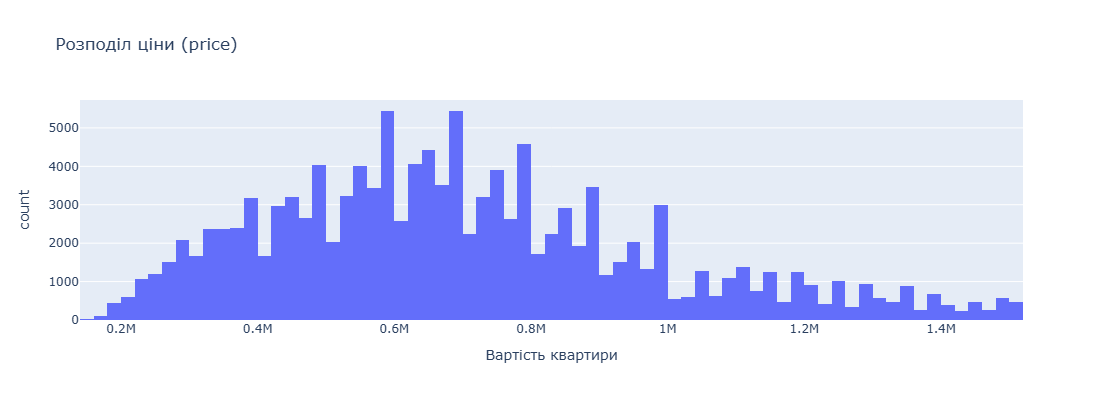

In [48]:
# Візуалізація цільової змінної
df_clean = rental_data.copy()
fig = px.histogram(df_clean, x='price', nbins=100, title='Розподіл ціни (price)',
                   labels={'price': 'Вартість квартири', 'count': 'Кількість'})
fig.update_layout(showlegend=False, height=400)
fig.show()


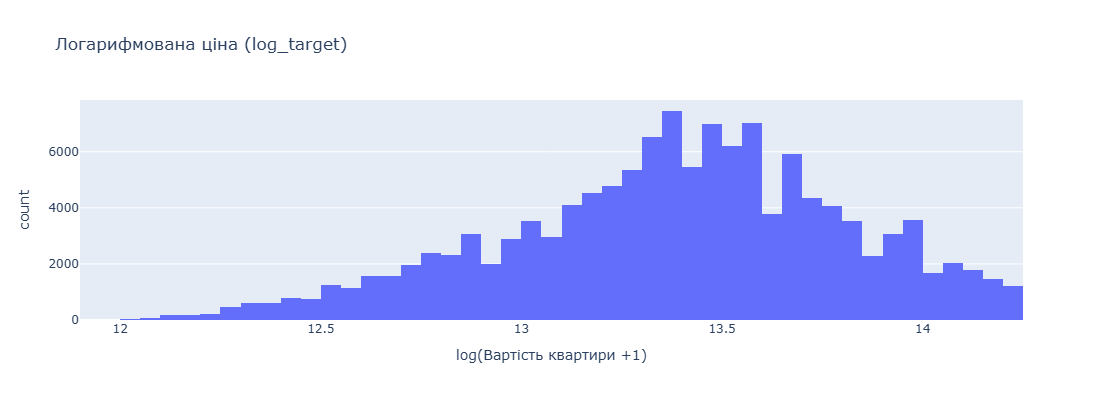

In [49]:
# Логарифмування
df_clean['log_target'] = np.log1p(df_clean['price'])
fig = px.histogram(df_clean, x='log_target', nbins=100, title='Логарифмована ціна (log_target)',
                   labels={'log_target': 'log(Вартість квартири +1)', 'count': 'Кількість'})
fig.update_layout(showlegend=False, height=400)
fig.show()


In [50]:
# Обчислюю матрицю кореляцій для числових змінних
corr_matrix = rental_data.corr(numeric_only=True)
print("Матриця кореляцій:")
corr_matrix.round(2)


Матриця кореляцій:


,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,price,price_per_m2
squareMeters,1.00,0.81,-0.10,-0.16,-0.02,0.05,-0.10,0.05,-0.02,0.09,0.05,0.08,0.09,0.08,0.06,0.09,0.53,-0.27
rooms,0.81,1.00,-0.05,-0.09,0.00,0.04,-0.05,0.06,-0.05,0.08,0.07,0.08,0.08,0.08,0.06,0.08,0.42,-0.25
floor,-0.10,-0.05,1.00,0.67,0.05,-0.01,0.08,-0.02,0.03,-0.10,-0.12,-0.08,-0.10,-0.09,-0.06,-0.10,0.01,0.10
floorCount,-0.16,-0.09,0.67,1.00,0.11,-0.02,0.11,-0.03,0.03,-0.14,-0.17,-0.10,-0.13,-0.13,-0.07,-0.13,0.04,0.18
buildYear,-0.02,0.00,0.05,0.11,1.00,-0.02,0.09,0.32,-0.33,0.23,0.23,0.21,0.11,0.15,0.31,0.18,0.18,0.20
latitude,0.05,0.04,-0.01,-0.02,-0.02,1.00,-0.23,0.08,-0.05,0.18,0.13,0.12,0.20,0.17,0.11,0.16,0.00,-0.04
longitude,-0.10,-0.05,0.08,0.11,0.09,-0.23,1.00,0.19,0.01,-0.09,-0.06,-0.04,-0.13,-0.10,0.01,-0.06,0.17,0.27
centreDistance,0.05,0.06,-0.02,-0.03,0.32,0.08,0.19,1.00,-0.46,0.29,0.43,0.26,0.14,0.23,0.53,0.26,0.15,0.09
poiCount,-0.02,-0.05,0.03,0.03,-0.33,-0.05,0.01,-0.46,1.00,-0.30,-0.37,-0.32,-0.21,-0.34,-0.44,-0.30,0.12,0.20
schoolDistance,0.09,0.08,-0.10,-0.14,0.23,0.18,-0.09,0.29,-0.30,1.00,0.56,0.77,0.79,0.78,0.34,0.81,0.04,-0.05


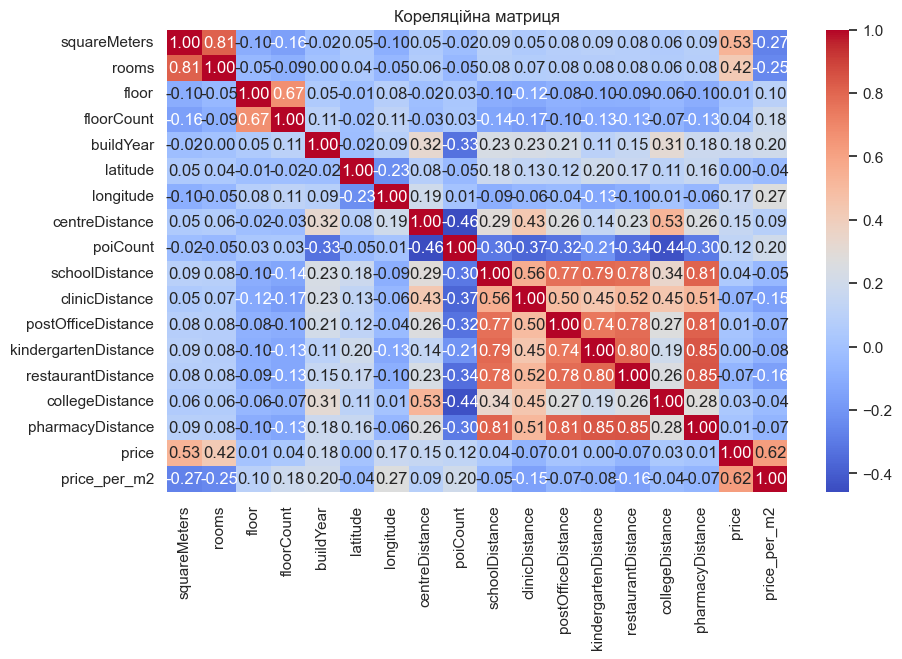

In [51]:
# Візуалізація кореляційної матриці за допомогою heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()


***Висновок:***

Кореляційна матриця підтверджує очікувану структуру даних: ціна тісно пов’язана з площею та кількістю кімнат, а інфраструктурні показники сильно між собою корельовані. Відстань від центру та щільність POI мають протилежний вплив, що вказує на просторову сегментацію ринку.

Загалом дані демонструють логічні зв’язки, однак для моделювання варто зменшити надлишкові корельовані змінні, щоб підвищити стабільність регресії.

Отже, вирішую визначити такі категорійні та числові ознаки для побудови моделі лінійної регресії:

In [52]:
# Створюю узагальнену ознаку для сильно корельованих груп - інфраструктурних відстаней, які показують наскільки далеко розвинена інфраструктура
rental_data["infraDistance_avg"] = rental_data[
    ["schoolDistance", "clinicDistance", "postOfficeDistance",
     "kindergartenDistance", "restaurantDistance", "pharmacyDistance"]
].mean(axis=1)


In [53]:
# Визначаю ознаки
categorical_cols = [
    "city", "type", "buildingMaterial", "hasParkingSpace",
    "hasBalcony", "hasElevator", "hasSecurity",
    "hasStorageRoom", "ownership"
]

numeric_cols = [
    "rooms", "floor", "floorCount", "buildYear",
    "squareMeters", "centreDistance", "infraDistance_avg"
]


In [54]:
# Фіксую порядок для city
city_order = ["warszawa"] + sorted(
    [c for c in rental_data["city"].unique() if c != "warszawa"]
)

# Енкодер для city 
city_encoder = OneHotEncoder(
    categories=[city_order],  # має бути список у списку!
    handle_unknown="ignore",
    drop="first"
)

# Енкодер для інших категорій
other_cat_encoder = OneHotEncoder(
    handle_unknown="ignore",
    drop="first"
)


In [55]:
# Побудова препроцесора
preprocessor = ColumnTransformer(
    transformers=[
        ("city", city_encoder, ["city"]),
        ("other_cat", other_cat_encoder,
         [c for c in categorical_cols if c != "city"]),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="drop"
)


In [56]:
# Вибір цільової змінної та ознак
X = rental_data.drop("price", axis=1)
y = rental_data["price"] / 1000  # у тис. злотих


In [57]:
# Розділення на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [58]:
# Модель
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [59]:
# Навчання моделі
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('city', ...), ('other_cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
# Перевірка
r2 = model.score(X_test, y_test)
print(f"✅ Модель успішно навчена. R²: {r2:.3f}")


✅ Модель успішно навчена. R²: 0.737


In [61]:
# Перевірка базового міста та ознак після трансформації
# Отримую підготовлений препроцесор із моделі
preprocessor_fitted = model.named_steps["preprocessor"]

# Отримую енкодери
city_encoder = preprocessor_fitted.named_transformers_["city"]
other_cat_encoder = preprocessor_fitted.named_transformers_["other_cat"]

# Категорії для ознаки "city"
city_categories = city_encoder.categories_[0]
base_city = city_categories[0]
print(f" Базове місто (відкинуте під час кодування): {base_city}")

# Назви ознак після трансформації
city_features = city_encoder.get_feature_names_out(["city"])
other_cat_features = other_cat_encoder.get_feature_names_out(
    [c for c in categorical_cols if c != "city"]
)

# Повний список ознак
all_features = numeric_cols + list(city_features) + list(other_cat_features)

print("\n Усі ознаки після трансформації:")
for f in all_features:
    print(f)


 Базове місто (відкинуте під час кодування): warszawa

 Усі ознаки після трансформації:
rooms
floor
floorCount
buildYear
squareMeters
centreDistance
infraDistance_avg
city_bialystok
city_bydgoszcz
city_czestochowa
city_gdansk
city_gdynia
city_katowice
city_krakow
city_lodz
city_lublin
city_poznan
city_radom
city_rzeszow
city_szczecin
city_wroclaw
type_blockOfFlats
type_tenement
buildingMaterial_concreteSlab
hasParkingSpace_yes
hasBalcony_yes
hasElevator_yes
hasSecurity_yes
hasStorageRoom_yes
ownership_cooperative
ownership_udział


In [62]:
# Отримую ColumnTransformer з пайплайну
preprocessor_fitted = model.named_steps["preprocessor"]

# Подивлюсь імена всіх трансформерів
print(preprocessor_fitted.named_transformers_.keys())


dict_keys(['city', 'other_cat', 'num', 'remainder'])


In [63]:
# Всі ознаки у порядку спадання за абсолютним впливом

# Отримую ColumnTransformer з пайплайну
preprocessor_fitted = model.named_steps["preprocessor"]

# Імена числових ознак
numeric_features = numeric_cols  # або preprocessor_fitted.named_transformers_['num'].feature_names_in_

# Імена ознак для "city"
city_features = preprocessor_fitted.named_transformers_['city'].get_feature_names_out(['city'])

# Імена інших категоріальних ознак
other_cat_features = preprocessor_fitted.named_transformers_['other_cat'].get_feature_names_out(
    [c for c in categorical_cols if c != 'city']
)

# Повний список ознак після трансформації
all_features = list(numeric_features) + list(city_features) + list(other_cat_features)

# Беру коефіцієнти з регресора
coefficients = model.named_steps["regressor"].coef_

# Формую DataFrame
coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coefficients
})

# Сортуюза абсолютним значенням у спадному порядку
coef_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)

# Виводжувсі ознаки
print("\n Усі ознаки у порядку спадання впливу:")
print(coef_df.to_string(index=False))



 Усі ознаки у порядку спадання впливу:
                      Feature  Coefficient
                  city_gdansk  -531.927895
                   floorCount  -529.160541
                        floor  -503.081930
               centreDistance  -465.037056
               city_bialystok  -450.951326
                        rooms  -433.834611
                city_katowice  -416.817259
                  city_gdynia  -398.610936
               city_bydgoszcz  -395.222307
             city_czestochowa  -331.742142
                  city_krakow  -223.609584
                 squareMeters  -199.116196
           hasStorageRoom_yes   159.110036
                    buildYear  -127.580032
            infraDistance_avg   -99.655289
                    city_lodz   -87.494544
                  city_lublin   -64.280278
        ownership_cooperative   -54.577833
                city_szczecin    44.692867
                  city_poznan   -31.120774
                 city_wroclaw    26.586353
buildingMateri

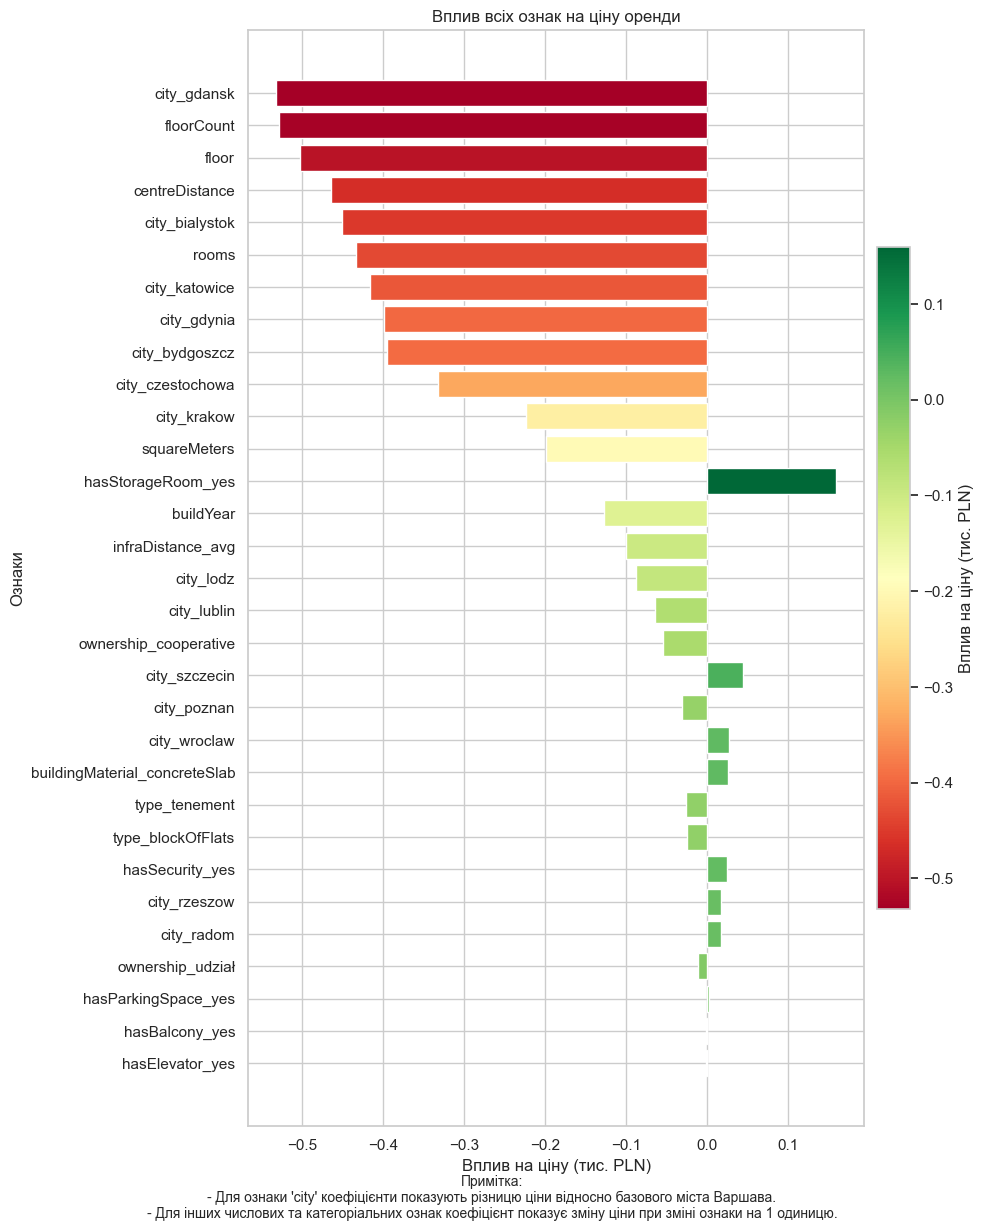

In [64]:
# Візуалізація всіх ознак
# Відновлюю шкалу коефіцієнтів у тис. злотих
coef_df_scaled = coef_df.copy()
coef_df_scaled["Coefficient"] = coef_df_scaled["Coefficient"] / 1000  # тис. злотих

# Сортую за абсолютним значенням
coef_df_sorted = coef_df_scaled.reindex(
    coef_df_scaled["Coefficient"].abs().sort_values(ascending=False).index
)

# Підготовка кольорів
norm = mpl.colors.Normalize(vmin=coef_df_sorted["Coefficient"].min(), vmax=coef_df_sorted["Coefficient"].max())
cmap = plt.cm.RdYlGn
colors = cmap(norm(coef_df_sorted["Coefficient"]))

# Горизонтальний графік
fig, ax = plt.subplots(figsize=(10, 12))
bars = ax.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"], color=colors)
ax.invert_yaxis()  # найбільший вплив вгорі
ax.set_xlabel("Вплив на ціну (тис. PLN)")
ax.set_ylabel("Ознаки")
ax.set_title("Вплив всіх ознак на ціну оренди")

# Додаю шкалу кольору праворуч
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label("Вплив на ціну (тис. PLN)")

# Пояснювальна примітка
note = (
    "Примітка:\n"
    "- Для ознаки 'city' коефіцієнти показують різницю ціни відносно базового міста Варшава.\n"
    "- Для інших числових та категоріальних ознак коефіцієнт показує зміну ціни при зміні ознаки на 1 одиницю."
)
plt.figtext(0.5, -0.02, note, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


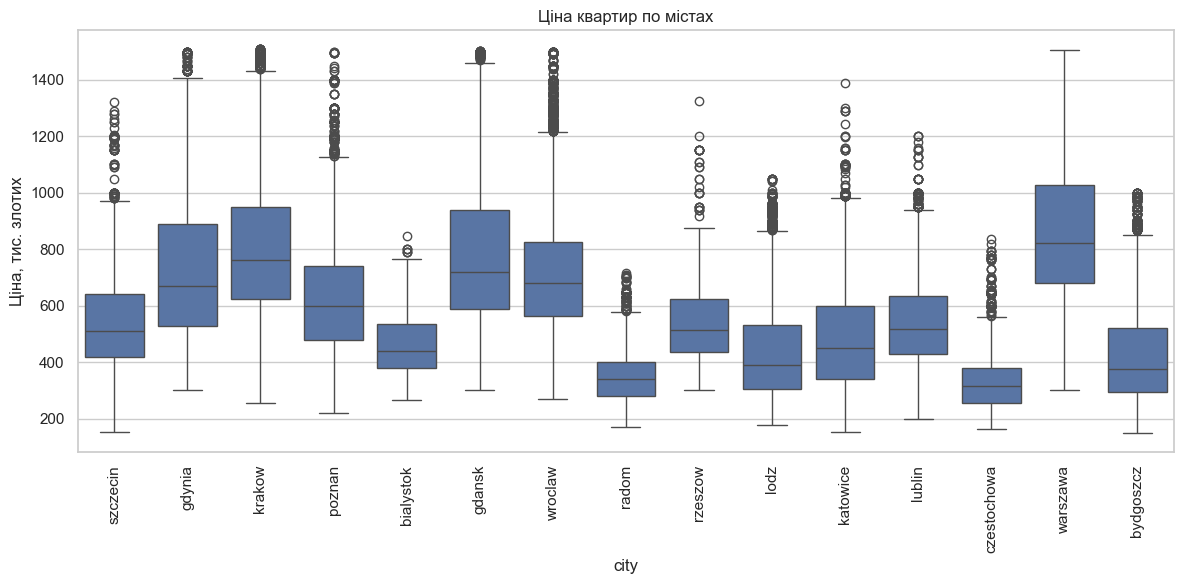

In [65]:
# Розподіли цін
# Створюю колонку з цінами у тис. злотих
rental_data['price_k'] = rental_data['price'] / 1000

# Boxplot по містах
if 'city' in rental_data.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=rental_data, x='city', y='price_k')
    plt.xticks(rotation=90)
    plt.ylabel("Ціна, тис. злотих")
    plt.title("Ціна квартир по містах")
    plt.tight_layout()
    plt.show()
    

## Оцінка якості моделі лінійної регресії

In [66]:
# Оцінка моделі на наявність переавчання
def evaluate_model(model, X_train, y_train, X_test, y_test, tolerance=0.05):
    """
    tolerance — допустима різниця R² між тренувальною та тестовою вибіркою
                 для визнання відсутності перенавчання (за замовчуванням 5%).
    """
    # Прогноз на тренувальній вибірці
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Прогноз на тестовій вибірці
    y_test_pred = model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Вивід результатів у єдиному стилі
    print("\n Оцінка моделі лінійної регресії (тис. злотих)")
    print(f"{'':<15}{'Train':>10}{'Test':>10}")
    print(f"{'R²':<15}{r2_train:>10.3f}{r2_test:>10.3f}")
    print(f"{'MAE':<15}{mae_train:>10.2f}{mae_test:>10.2f}")
    print(f"{'RMSE':<15}{rmse_train:>10.2f}{rmse_test:>10.2f}")

    # Автоматична оцінка перенавчання
    r2_diff = r2_train - r2_test
    if r2_diff > tolerance:
        print("\n⚠️ Можливе перенавчання: R² на тренуванні значно вищий, ніж на тесті.")
    else:
        print("\n✅ Перенавчання відсутнє: модель добре узагальнює на нових даних.")

# Виклик функції
evaluate_model(model, X_train, y_train, X_test, y_test)



 Оцінка моделі лінійної регресії (тис. злотих)
                    Train      Test
R²                  0.740     0.737
MAE                109.39    109.72
RMSE               145.31    145.97

✅ Перенавчання відсутнє: модель добре узагальнює на нових даних.


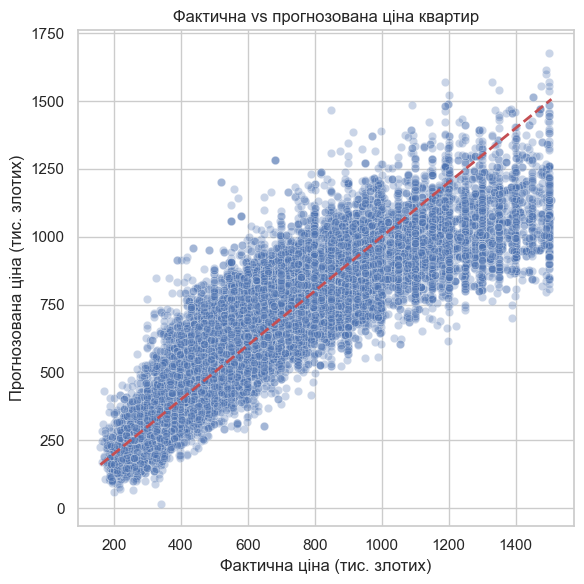

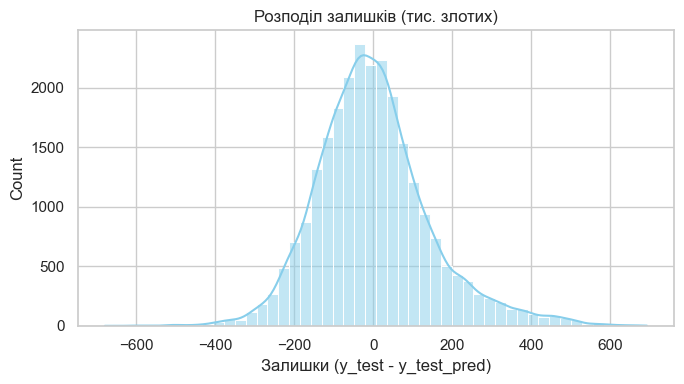

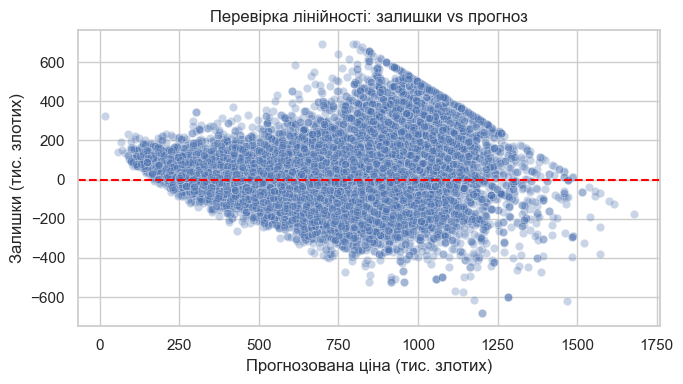

In [67]:
# Візуалізація результатів моделі
# (на основі попереднього evaluate_model)

# Прогноз на тестових даних
y_test_pred = model.predict(X_test)

# --- 1. Фактична vs Прогнозована ціна ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Фактична ціна (тис. злотих)")
plt.ylabel("Прогнозована ціна (тис. злотих)")
plt.title("Фактична vs прогнозована ціна квартир")
plt.tight_layout()
plt.show()

# --- 2. Розподіл залишків ---
residuals = y_test - y_test_pred
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=50, kde=True, color="skyblue")
plt.title("Розподіл залишків (тис. злотих)")
plt.xlabel("Залишки (y_test - y_test_pred)")
plt.tight_layout()
plt.show()

# --- 3. Залишки vs Прогноз ---
plt.figure(figsize=(7,4))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Прогнозована ціна (тис. злотих)")
plt.ylabel("Залишки (тис. злотих)")
plt.title("Перевірка лінійності: залишки vs прогноз")
plt.tight_layout()
plt.show()


### Висновки

R²: 0.74 (пояснює 74% варіації цін), майже однаковий на тренувальній та тестовій вибірках (0.740 vs 0.737)

MAE: 109,7 тис. PLN (~14% від середньої ціни)

RMSE: 146 тис. PLN (~19% від середньої ціни)

MAE і RMSE теж дуже близькі. Немає великої різниці між помилками на тренуванні та тесті.
Отже, модель не перенавчена. Вона добре узагальнює на нових даних і адекватно прогнозує ціни.


***Найбільший вплив на ціну мають:***

- Місто розташування: Гданськ, Білосток, Катовіце знижують ціну; Сеццин і Вроцлав підвищують.

- Фізичні характеристики: загальна кількість поверхів в будинку, поверх квартири, відстань до центру, кількість кімнат. Ці базові характеристики квартири та будинку істотно впливають на її ціну:

***Загальна кількість поверхів в будинку***

Високоповерхові будинки часто розташовані в центральних районах, але можуть мати різний попит.

Модель показує, що зростання кількості поверхів може зменшувати або збільшувати ціну залежно від інших факторів (наприклад, комфорт, ліфт, стан будинку).

***Поверх квартири***

Квартира на першому або останньому поверсі може коштувати менше (перший — шум, волога; останній — спека, дах) або більше (останній з гарним видом).

Модель враховує, що ці відмінності статистично впливають на ціну.

***Відстань до центру***

Чим ближче квартира до центру міста, тим дорожча зазвичай.

Це класичний фактор «локалізації», який сильно корелює з ціною.

***Кількість кімнат***

Більше кімнат → більша площа → вища ціна.

Це пряма фізична характеристика, яка показує масштаб квартири.


- Додаткові атрибути: наявність комірки для зберігання підвищує ціну; будівельний рік і тип володіння мають менший, але помітний вплив.

- Інші фактори: наявність паркувального місця, балкону чи ліфта мають незначний вплив.

***Отже, ключовими драйверами вартості квартири залишаються місто та базові характеристики житла, тоді як допоміжні фактори коригують ціну помірно.***

## 7 Додаткові візуалізації для відповіді на поставлені питання

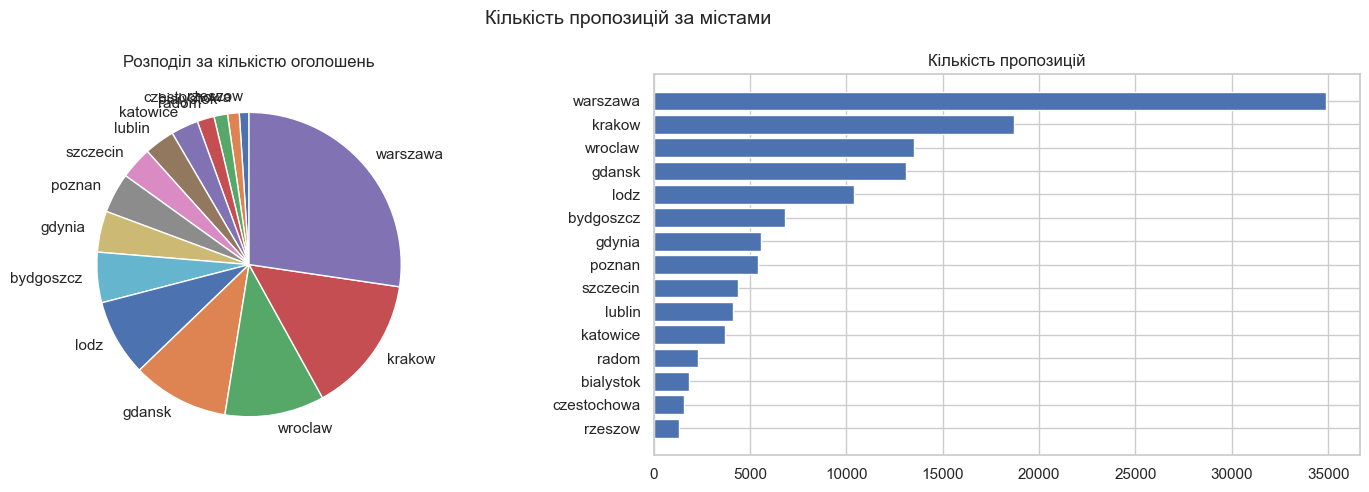

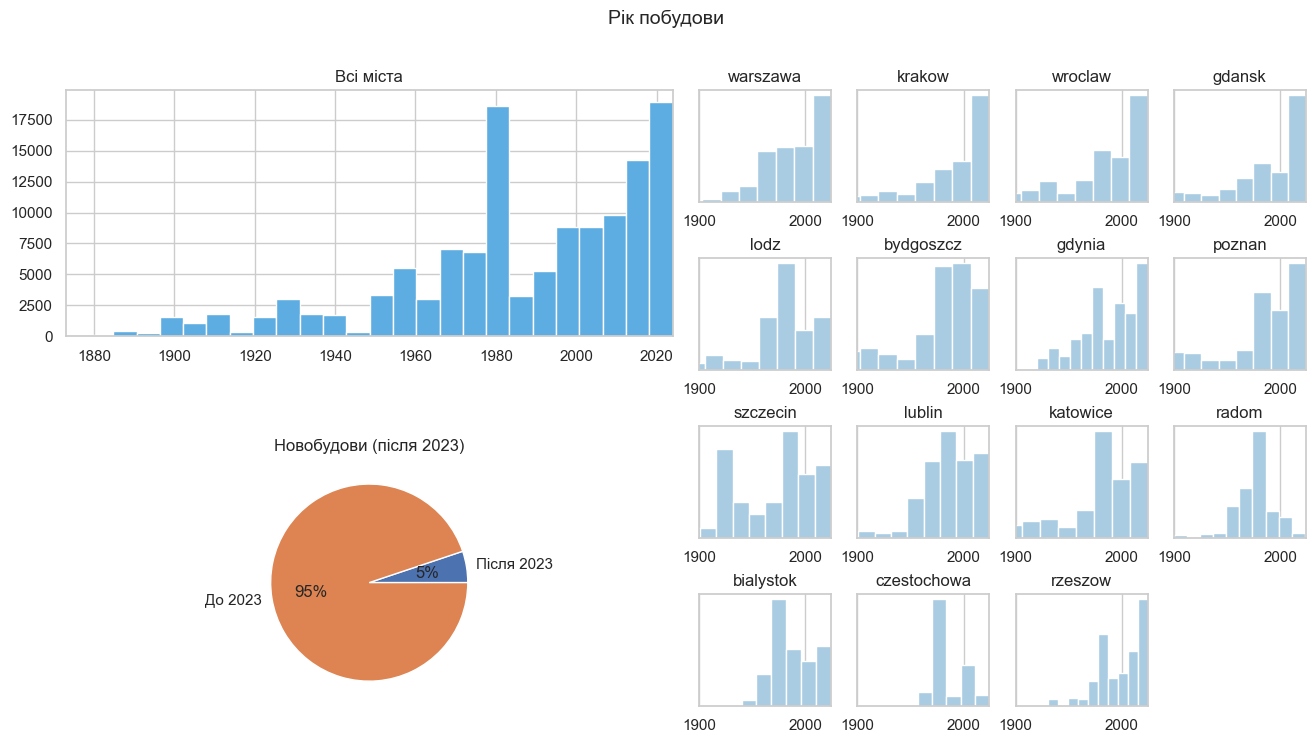

In [68]:
# Рік побудови
# Підготовка даних
city_names = rental_data["city"].unique()
city_data = {"all cities": rental_data}

for city in city_names:
    city_data[city] = rental_data[rental_data["city"] == city]

city_stats = (
    rental_data.groupby("city")["price"]
    .count()
    .reset_index()
    .rename(columns={"price": "count"})
    .sort_values("count", ascending=True)
)

# Графік кількості пропозицій по містах
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Кількість пропозицій за містами", fontsize=14)

# Кругова діаграма
axes[0].pie(city_stats["count"], labels=city_stats["city"], startangle=90)
axes[0].set_title("Розподіл за кількістю оголошень")

# Горизонтальний barplot
axes[1].barh(city_stats["city"], city_stats["count"])
axes[1].set_title("Кількість пропозицій")
plt.tight_layout()
plt.show()

# Рік побудови
city_names_sorted = city_stats["city"].tolist()
city_names_sorted.reverse()

fig = plt.figure(figsize=(16, 8))
fig.suptitle("Рік побудови", fontsize=14)

# Всі міста
ax_all = fig.add_subplot(2, 8, (1, 4))
ax_all.set_title("Всі міста")
ax_all.hist(rental_data["buildYear"], bins=30, color="#5DADE2")
ax_all.set_xlim(1873, 2024)

# Новобудови
ax_new = fig.add_subplot(2, 8, (9, 12))
ax_new.set_title("Новобудови (після 2023)")
ax_new.pie(
    [
        len(rental_data[rental_data["buildYear"] >= 2023]),
        len(rental_data[rental_data["buildYear"] < 2023]),
    ],
    autopct=lambda x: f"{round(x)}%",
    labels=["Після 2023", "До 2023"],
)

# Окремо по містах
for i, city in enumerate(city_names_sorted):
    ax = fig.add_subplot(4, 8, i + 5 + 4 * math.floor(i / 4))
    ax.set_title(city)
    ax.hist(city_data[city]["buildYear"], bins=10, color="#A9CCE3")
    ax.yaxis.set_visible(False)
    ax.set_xlim(1900, 2024)

plt.subplots_adjust(hspace=0.5)
plt.show()


### Відповіді на запитання, які були поставлені на початку проведення аналізу даних

***1 Які фактори (ознаки) найбільше впливають на ціну квартири?***

Найбільший вплив на ціну мають:

Місто — квартири у великих містах дорожчі.

Загальна кількість поверхів у будинку та поверх квартири — високі поверхи з меншим числом пропозицій дорожчі, популярні нижні та середні поверхи — дешевші.

Відстань до центру — чим ближче, тим вища ціна.

Кількість кімнат та площа квартири.

***2 Як змінювалися ціни на квартири з серпня 2023 р. до червня 2024 р.?***

Середня вартість 1 м² по всіх містах зростала незначно: з ~12 000 PLN у квітні 2023 до ~14 000 PLN у червні 2024.
Зміни по містах можна переглянути на дашборді.

***3 Який рік побудови переважає в оголошеннях?***

Найбільше квартир у датасеті побудовано у 1980 році — 11 760 одиниць.
ТОП-3 років включає також 2023 рік (6 348 квартир) та 2022 рік (6 007 квартир), що свідчить про зростання кількості новобудов.
Присутні і старі будівлі кінця XIX — початку XX ст. (1856–1884 рр.), що впливає на середню ціну та попит.

***4 Як змінюється ціна залежно від міста/регіону (топ-5 міст за середньою ціною)?***

Відносно Варшави:

Сцеццин і Вроцлав підвищують ціну.

Гданськ, Білосток, Катовіце — знижують.

***5 Вплив площі та кількості кімнат на ціну***

Зі збільшенням площі зростає загальна ціна (коеф. кореляції з ціною 0.53).

Великі квартири дорожчі загалом, але дешевші за 1 м² (негативна кореляція з price_per_m² −0.27).

***6 Залежність ціни від відстані до центру***

Чим ближче квартира до центру, тим дорожча, що відповідає класичному фактору «локалізації».

***7 Вплив типу житла (матеріалу будівлі)***

Найдорожчі — цегляні будинки.

Найдешевші — панельні (concreteSlab).

***8 Додаткові характеристики, що впливають на ціну***

Поверх: перший та останній поверхи можуть бути дешевші або дорожчі залежно від умов (шум, вид, спека).

Наявність комірки для зберігання підвищує ціну.

Будівельний рік та тип власності мають менший, але помітний вплив.

Ліфт, балкон, паркувальне місце — незначний вплив.

Висновок: ключові драйвери вартості — місто та базові характеристики житла; допоміжні фактори коригують ціну помірно.

***9 Регіональна різниця в волатильності цін***

У великих містах (Варшава, Краків) пропозицій більше, але площа трохи менша.

Найбільша середня площа квартир — у Сцеццині та Гдині (~64–66 м²).

Найменша — у Білостоці та Ченстохові (~53 м²).

***10 Якість моделі регресії та перенавчання***

Модель лінійної регресії пояснює 74 % варіації цін, що є хорошим результатом для ринку з високою варіативністю.

Помилки: MAE ~110 тис. PLN, RMSE ~146 тис. PLN — характерні для нерухомості.

Модель стабільна та надійна для прогнозування цін.


## 🔑 5 ключових інсайтів про ринок квартир у Польщі

***Місто формує ціну***

Варшава, Краків і Вроцлав — найдорожчі, Білосток та Ченстохова — дешевші, навіть при великій площі.

***Новобудови активно зростають***

2022–2023 рр. демонструють підвищення кількості квартир, особливо у великих містах, що змінює пропозицію на ринку.

***Площа та поверх важливі, але не критичні***

Великі квартири дорожчі загалом, але дешевші за м²; високі поверхи з малою пропозицією — дорожчі, перший/останній поверх — можуть коштувати менше.

***Стабільність цін у короткостроковій перспективі***

Вартість 1 м² залишалася майже стабільною: 12 → 14 тис. PLN (серпень 2023 – червень 2024).

***Додаткові фактори дають невелику премію***

Наявність комірки для зберігання, будівельний рік та тип власності трохи підвищують ціну; ліфт, балкон, паркування — незначний вплив.

## Скріншот дашборду

<p align="center">
  <img src="../dashboard.png" width="700">
</p>
